# Non-Adaptive Preconditioned Consistent Bayes

This is a notebook for implementing preconditioned rejection sampling for the consistent Bayesian approach. Samples are used to compute the push-forward of the prior. Rejection sampling is then applied to these samples to generate samples from the posterior. We apply Gaussian Kernel Density Estimation to these posterior samples to generate an approximation to the posterior pdf and use this to formulate a new proposal distribution that yields a better acceptance rate.

## Import neccesary libraries

In [6]:
import numpy as np
# Using "%matplotlib notebook" for more interactive plots
%matplotlib notebook 
# %matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import scipy.stats as sstats
from scipy.stats import gaussian_kde as gkde
from scipy.stats import shapiro as shapiro

In [8]:
# from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier%matplotlib inline

# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans

---


## Sample uniformly from $\Lambda=[-1,1]\times[-1,0]\subset\mathbb{R}^2$

In [9]:
num_samples = int(1E4)

# Uniform sampling
lam = np.random.uniform(low=[-1.,-1.],high=[1.,0.],size=(num_samples,2))

# Gaussian sampling
#lam = np.random.normal(loc=([0.0,-0.5]),scale=([0.5,0.5]),size=(num_samples,2))
   
lam = np.transpose(lam)

<IPython.core.display.Javascript object>


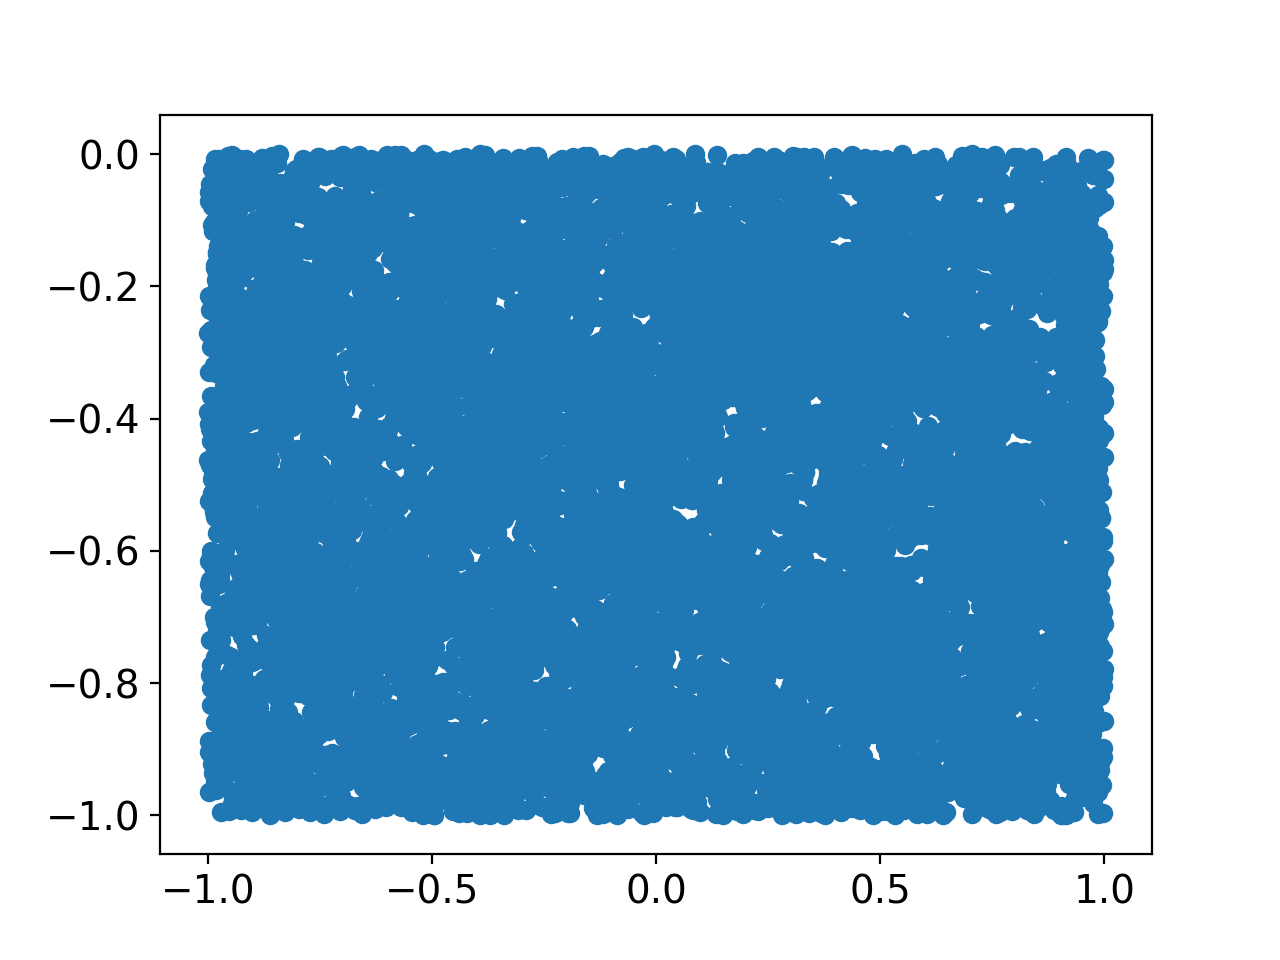

In [10]:
plt.figure()

plt.scatter(lam[0,:],lam[1,:])
plt.show()

## QoI defined by the rosenbrock function

In [12]:
def rosenbrock(x): # this takes in (dim x 2)
    q = (1.-x[0])**2. + 100*(x[1]-x[0]**2.)**2.
    return q

## Compute the QoI Samples

In [13]:
q = rosenbrock(lam)

## Compute the push-forward of prior

In [14]:
pf_dens = gkde(q)

## Define the observed density

In [96]:
mu = 100.0
sigma = 12.0

obs_dens = sstats.norm(mu,sigma)

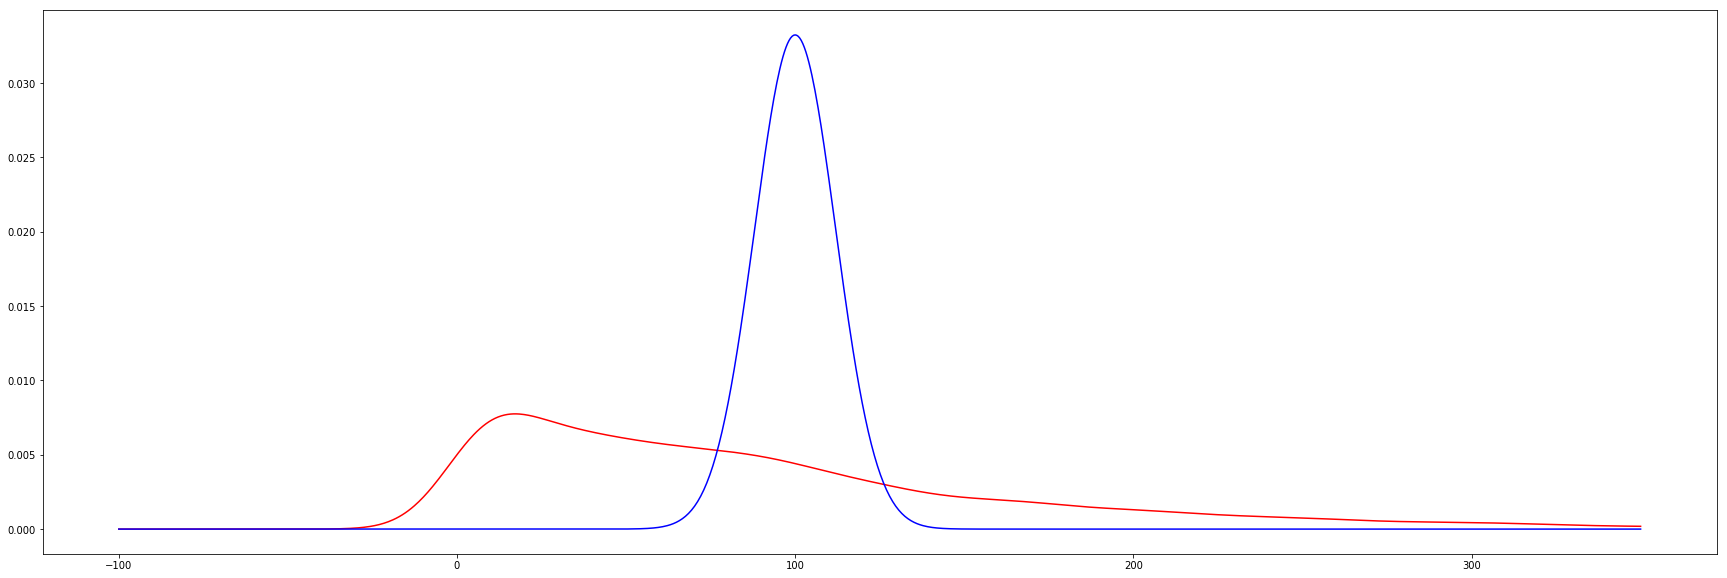

In [97]:
x = np.linspace(-100.0,350.0,1000)

plt.figure()

plt.plot(x,pf_dens.evaluate(x),'r')
plt.plot(x,obs_dens.pdf(x),'b')
plt.show()

## Perform accept/reject on the prior samples

In [98]:
lam_accept = []
r = obs_dens.pdf(q)/pf_dens.evaluate(q)
M = np.max(r)
eta_r = r/M
accept_inds = [i for i in range(num_samples) if eta_r[i] > np.random.uniform(0,1) ]
# for i in range(num_samples):
#     xi = np.random.uniform(0,1)
#     if eta_r[i] > xi:
#         lam_accept.append(lam[:,i])

# # Make accepted samples into array object
# lam_accept = np.array(lam_accept)
# lam_accept = np.transpose(lam_accept)

In [99]:
lam_accept = lam[:,accept_inds]

In [100]:
print(lam_accept.shape)

count = lam_accept.shape[1]
print("Acceptance rate is %2.2f%%"%(100*float(count)/float(num_samples) ) )

(2, 1317)
Acceptance rate is 13.17%


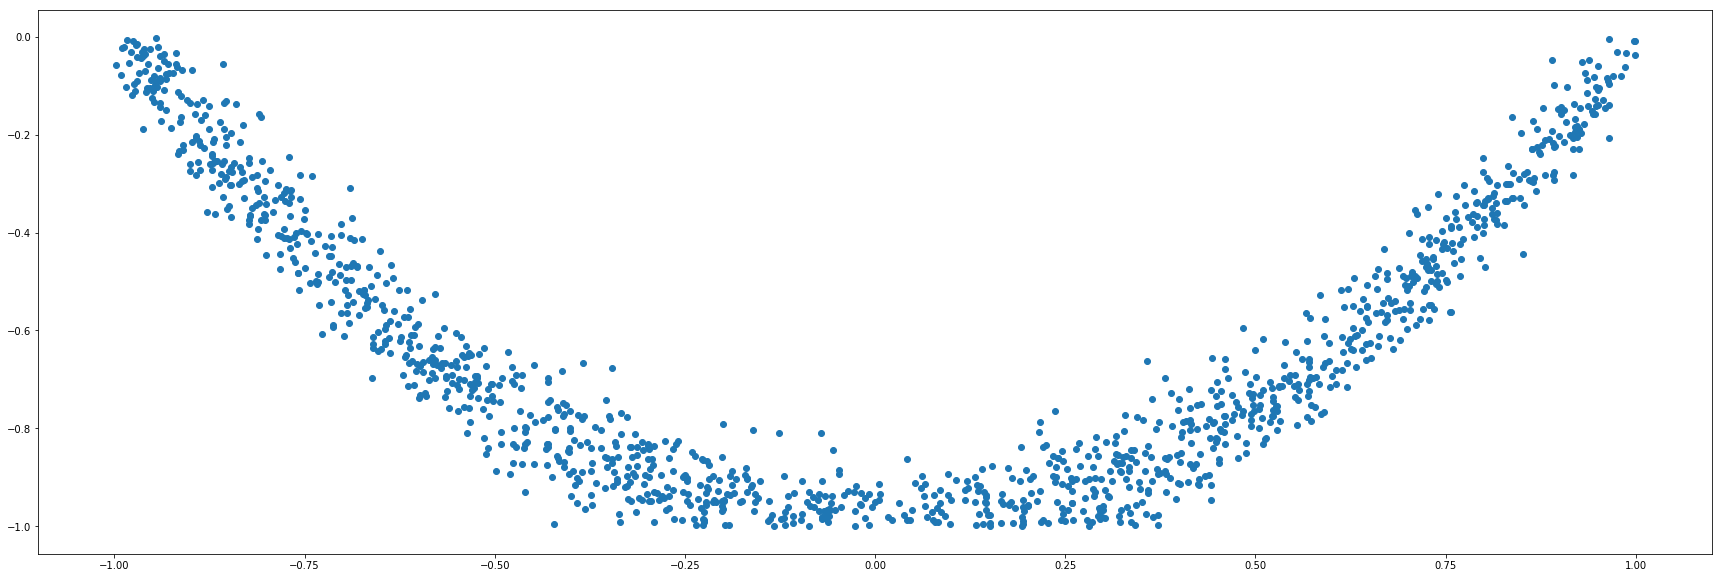

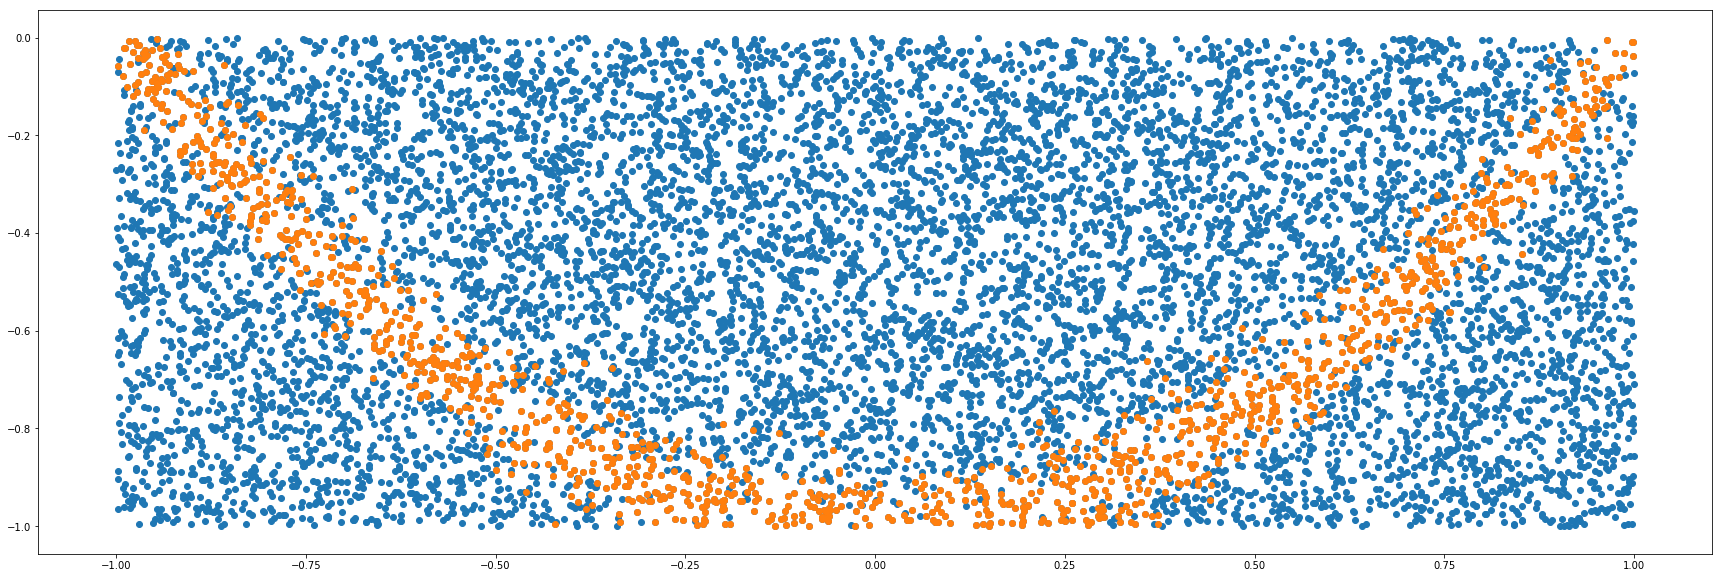

In [101]:
plt.figure()
plt.scatter(lam_accept[0,1:],lam_accept[1,1:])
plt.show()

plt.figure()
plt.scatter(lam[0,:],lam[1,:])
plt.scatter(lam_accept[0,1:],lam_accept[1,1:])
plt.show()

## Now that the posterior density has been computed, we attempt to apply our ML algorithm.

The algorithm simply expects a `(n x 2)` `X` and `(n x 1)` `y` variable.

### First, to the (continuous) density values:

In [102]:
# X = lam.transpose()
# y = np.zeros(len(X))
# y[accept_inds] = 1
# # y = eta_r > 0.5

In [103]:
# y = y*1 # convert to int

# compare(X,y)

In [104]:
lam_accept.shape

(2, 1317)

### Next, to the accepted samples:


In [114]:
rstate = 42 # random state.
sc = StandardScaler()

X = lam_accept.transpose()
X_sc = sc.fit_transform(X) # scale data to normalized

# train_size = 0.2

# X_train, X_test = \
#     train_test_split(X, test_size= 1.0 - train_size, random_state=rstate)

# sc = StandardScaler() # instantiate class which keeps track of scaling info.
# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.transform(X_test)
X_train_sc = X_sc # use the entirety of the accepted samples. The downside of this is that you don't 

h = 0.05 # mesh parameter for plotting
buff = 0.1 # buffer for plotting
x_min, x_max = X_train_sc[:, 0].min() - buff, X_train_sc[:, 0].max() + buff
y_min, y_max = X_train_sc[:, 1].min() - buff, X_train_sc[:, 1].max() + buff
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # mesh params unscaled

num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=rstate).fit(X_train_sc)

from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier%matplotlib inline

# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# kmeans.labels_
# kmeans.cluster_centers_
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# score = kmeans.score(X_test_sc)

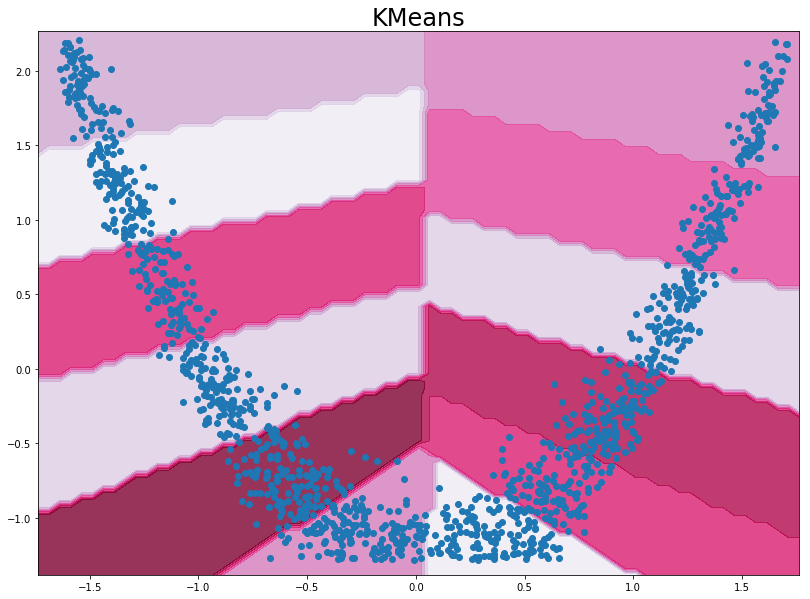

In [115]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 10)
plt.figure()

ax = plt.subplot(1,2,1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.PuRd, alpha=.8)
ax.scatter(X_train_sc[:,0], X_train_sc[:,1])
# ax.scatter(X_test_sc[:,0], X_test_sc[:,1], c='k', alpha=0.05)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title('KMeans', fontsize=24)
# ax.text(xx.max() - buff, yy.min() + buff, ('%.2f' % score).lstrip('0'), size=25, horizontalalignment='right')
plt.show()

In [116]:
kmeans.cluster_centers_[0]

array([ 0.35703532, -1.11624088])

In [117]:
# svd
labels = kmeans.labels_
# for k in range(num_clusters): # for each cluster k
D = { k: {'center': sc.inverse_transform( kmeans.cluster_centers_[k] ), 
         'samples': lam_accept[:, labels == k].transpose()}
     for k in range(np.unique(labels).size) }

# print out what D is holding
# num_samps = 2
# for k in D.keys():
#     print('index:', k, '\ncenter:', D[k]['center'], 
#           '\nfirst few samples:\n', D[k]['samples'][0:num_samps,:], '\n')

In [118]:
def lcl_pca(D):
    # the keys of the dictionary are labels for the clusters
    dim = len(D[0]['center'])
    for k in D.keys():
        lam_local = D[k]['samples']
        num_local_samples = len(lam_local)
        c = D[k]['center']
        L = lam_local - c # center the samples at the origin in order to perform SVD
        S = np.linalg.svd(L)
        B = S[2] # grab the eigenbasis for the subspace
        # now we project our samples onto this orthonormal basis (hence no denominator in projection formula)
        D[k]['proj_samples'] = {}
        for d in range(dim):
            Lp =  [np.inner( B[:,d], L[i,:])*B[:,d] for i in range(num_local_samples) ]
            Lp = np.array(Lp) + c
            D[k]['proj_samples'][d] = Lp # store the projections as a dictionary in a new key
#     return D # dictionaries are passed by reference, so no need to return anything?

### Perform Projections on dictionary object that holds our clusters.

In [119]:
lcl_pca(D)

### Visualize results (2D only)

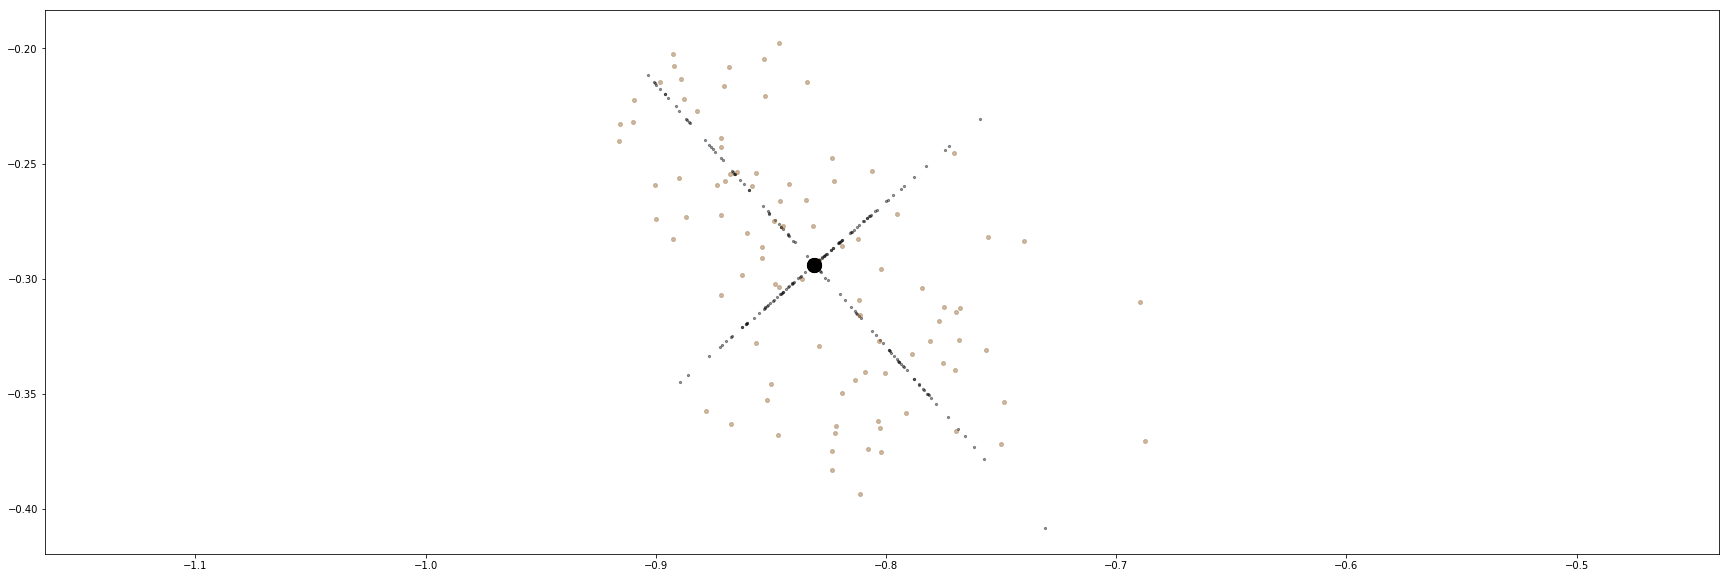

In [120]:
k=1
c = D[k]['center']
plt.figure()
for d in D[k]['proj_samples'].keys(): # for each axis
    lam_local = D[k]['samples']
    plt.scatter(lam_local[:,0], lam_local[:,1], s=15, alpha=0.3)
    lam_local_proj = D[k]['proj_samples'][d] # grab projected samples3
    plt.scatter(lam_local_proj[:,0], lam_local_proj[:,1], c='k', s=5, alpha=0.4)
    plt.scatter(c[0], c[1], s=200, c='k')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


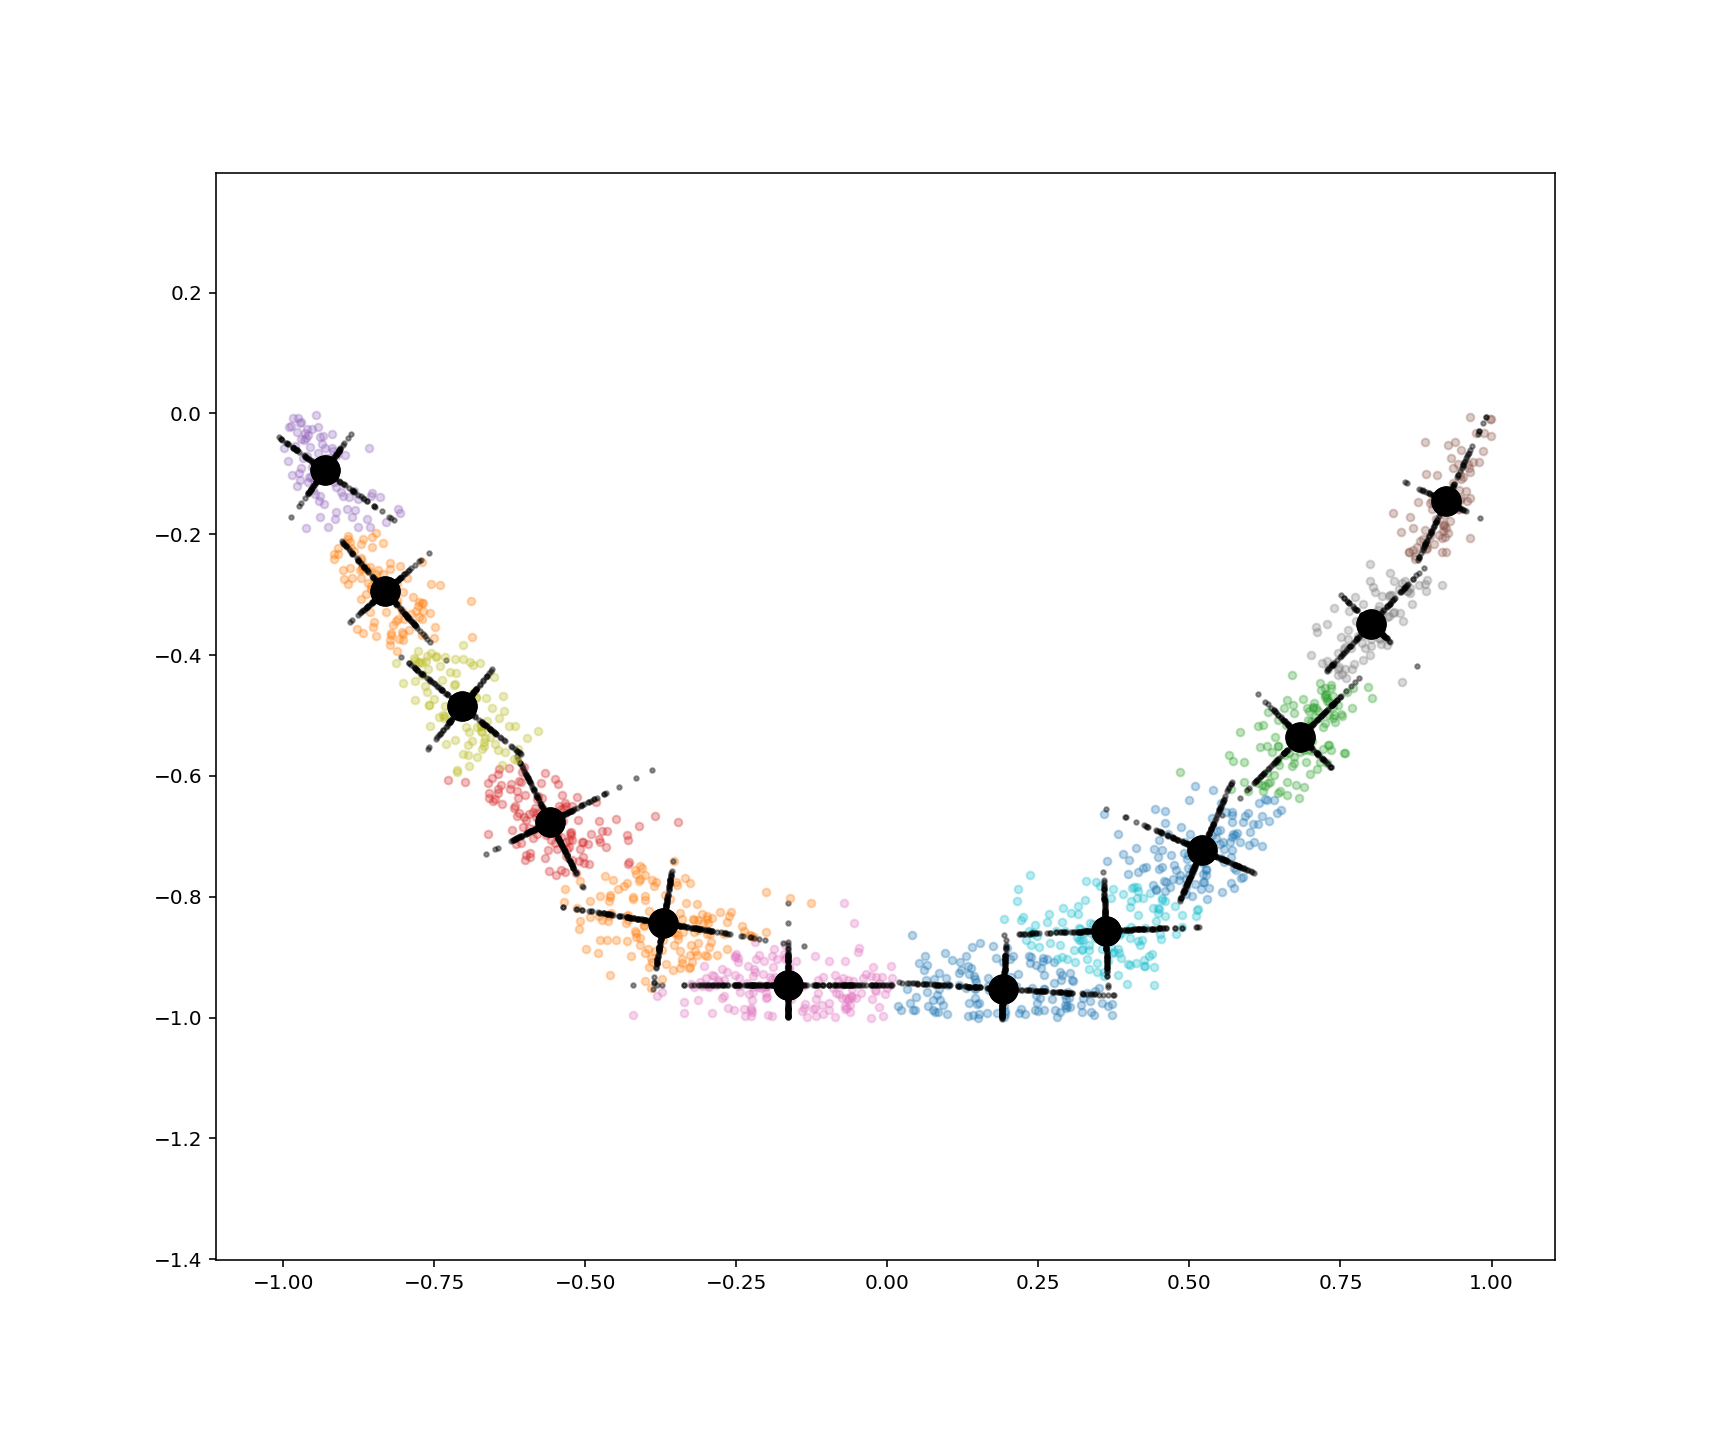

In [122]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (12, 10)

plt.figure()
for k in D.keys(): # for each subspace
    lam_local = D[k]['samples']
    plt.scatter(lam_local[:,0], lam_local[:,1], s=15, alpha=0.3)
    c = D[k]['center']
    for d in D[k]['proj_samples'].keys(): # for each axis
        lam_local_proj = D[k]['proj_samples'][d] # grab projected samples
        plt.scatter(lam_local_proj[:,0], lam_local_proj[:,1], c='k', s=5, alpha=0.4)
        plt.scatter(c[0], c[1], s=200, c='k')
plt.axis('equal')
plt.show()

### Fit Parametric Distributions

In [66]:
prior_type = 'uniform'
obs_type = 'normal'
oberved_density = sstats.norm(loc=100., scale=6.)
prior_density = sstats.uniform(loc=-1, scale = 2)

def fit_dist(D, prior_type, ob_type):
    handles = ['pr', 'ob']
    for k in D.keys():
        D[k]['parametric'] = {d: {dist: {'loc': None, 'scale': None, 'fit': None} for dist in handles}  
                              for d in D[k]['proj_samples'].keys() }
#         print( D[k]['parametric'] )
        for d in D[k]['proj_samples'].keys(): 
            lcl_proj_samps = D[k]['proj_samples'][d][:,d]
            
            for idx, dist in enumerate([prior_type, ob_type]): # we have to figure out which axis is associated with distribution
                if dist == 'normal':
                    lcl_loc = np.mean(lcl_proj_samps)
                    lcl_scale = np.std(lcl_proj_samps) # std or var? I think std
                    D[k]['parametric'][d][ handles[idx] ]['loc'] = lcl_loc
                    D[k]['parametric'][d][ handles[idx] ]['scale'] = lcl_scale
                    D[k]['parametric'][d][ handles[idx] ]['fit'] = sstats.kstest(lcl_proj_samps,  sstats.norm(loc=lcl_loc, scale=lcl_scale).cdf)[1]
                elif dist == 'uniform':
                    lcl_loc = np.min(lcl_proj_samps) # left endpoint
                    lcl_scale = np.max(lcl_proj_samps) - lcl_loc # interval length
                    D[k]['parametric'][d][ handles[idx] ]['loc'] = lcl_loc
                    D[k]['parametric'][d][ handles[idx] ]['scale'] = lcl_scale
                    D[k]['parametric'][d][ handles[idx] ]['fit'] = sstats.kstest(lcl_proj_samps,  sstats.uniform(loc=lcl_loc, scale=lcl_scale).cdf)[1]
               
        # now that we've computed all the test stats for this cluster, we decide which is which
        # figure out which dimension fits the oberved best and prior best:
        ob_fits = [D[k]['parametric'][d]['ob']['fit'] for d in D[k]['proj_samples'].keys() ]
        pr_fits = [D[k]['parametric'][d]['pr']['fit'] for d in D[k]['proj_samples'].keys() ]
        
        # this loop will select the best fit, but sometimes that means the mixture might end up being ob/ob... which we dont want.
#         for d in D[k]['proj_samples'].keys(): 
#             # if the prior fits better than the ob:
#             if D[k]['parametric'][d][ handles[0] ]['fit'] > D[k]['parametric'][d][ handles[1] ]['fit']:
#                 D[k]['parametric'][d]['dist'] = {'type': prior_type, 
#                                                  'loc': D[k]['parametric'][d][ handles[0] ]['loc'],
#                                                  'scale': D[k]['parametric'][d][ handles[0] ]['scale']}
#             else:
#                 D[k]['parametric'][d]['dist'] = {'type': ob_type, 
#                                                  'loc': D[k]['parametric'][d][ handles[1] ]['loc'],
#                                                  'scale': D[k]['parametric'][d][ handles[1] ]['scale']}
            

In [68]:
k = 1
# lcl_proj_samps = D[k]['proj_samples'][d]
fit_dist(D, prior_type, obs_type)
[D[k]['parametric'][d]['ob']['fit']  for d in D[k]['proj_samples'].keys() ]

[0.9990106216657874, 0.9373932809342026]

In [69]:
[D[k]['parametric'][d]['pr']['fit']  for d in D[k]['proj_samples'].keys() ]

[0.1628095766351565, 0.34740462092457536]

In [263]:
k, d = 1, 1
# lcl_proj_samps = D[k]['proj_samples'][d]
fit_dist(D, prior_type, obs_type)
D[k]['parametric'][d]


{'ob': {'fit': 0.043972993267714644,
  'loc': -0.8538914179822994,
  'scale': 0.15545481986508727},
 'pr': {'fit': 0.004537307263971835,
  'loc': -1.1069461976012083,
  'scale': 0.5580357703598837}}

For `k = 1` 
`d=0` is clearly favoring obs.
`d=1` also favors obs though. By a factor of 10. 


(array([18., 20., 31., 30., 18., 32., 18., 17., 18., 22.]),
 array([-1.04393133, -1.00493999, -0.96594866, -0.92695733, -0.887966  ,
        -0.84897467, -0.80998334, -0.77099201, -0.73200068, -0.69300934,
        -0.65401801]),
 <a list of 10 Patch objects>)

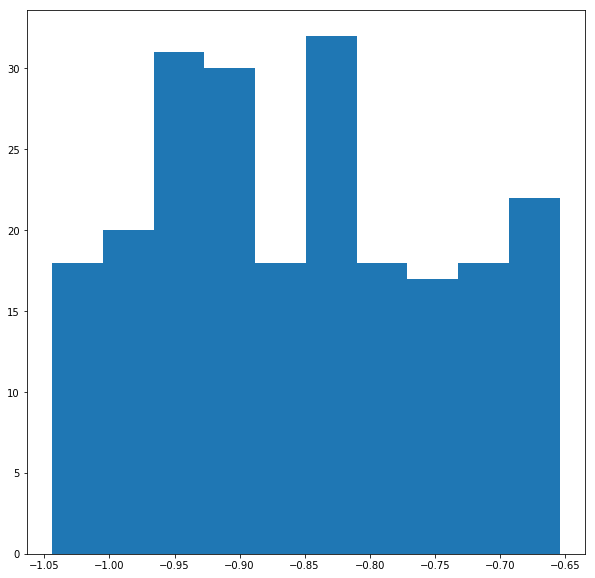

In [37]:
plt.hist(proj[1,:],bins=10)

TypeError: interval() missing 1 required positional argument: 'alpha'

In [201]:
# run wilkes-barre test
x = sstats.norm.rvs(loc=5, scale=3, size=1000)
shapiro(x)

(0.9986359477043152, 0.6453028917312622)

In [206]:
(sstats.kstest(x, sstats.uniform(loc=0.0, scale=10).cdf), sstats.kstest(x, sstats.norm(loc=5, scale=3.0).cdf) )

(KstestResult(statistic=0.06378373944417381, pvalue=0.0005576850299471303),
 KstestResult(statistic=0.03067315849532204, pvalue=0.29850586274919966))

In [ ]:
shapiro(proj[1,:])

In [ ]:
np.mean(proj[1,:])

In [ ]:
np.std(proj[1,:])

In [ ]:
# sur = sstats.norm( loc=np.mean(proj[1,:]), scale=np.std(proj[1,:]))
surr = sstats.uniform(loc=np.min(lam_local), scale=np.max(lam_local)-np.min(lam_local))

In [ ]:
X = np.dot(S[0], np.array([surr.rvs(size=100), sur.rvs(size=100)]) ) + c[:,0]

In [ ]:
plt.scatter(X[0,:], X[1,:])
plt.scatter(lam_local[0,:], lam_local[1,:])
